In [1]:
import numpy as np
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt
from ldpc import BpOsdDecoder
from ldpc.bplsd_decoder import BpLsdDecoder

In [2]:
sys.path.append("/home/sajant/Research/Berkeley/QEC/BP-Loop-Decoding/codes/")

In [3]:
import toric

In [4]:
sys.path.append("/home/sajant/Research/Berkeley/QEC/pyfssa/")
import fssa

# Phase flip noise - Toric code

## Line-by-line verification
We want to correct phase noise using MWPM. We do the following.
1. Generate the parity check matrix $H$ and logical operators $L$ for the X sector of the Toric code. We want the X stabilziers (logicals) as these anticommute with the Z noise (combined noise + recovery string)
2. Given an independent phase flip error rate $p$, sample an error string $e$. This is where the $Z$ errors are applied.
3. Compute the syndrome $s = (H @ e) \: \% \: 2$, which tells us which stabilizers are violated.
4. Use `PyMatching` to infer the most probable *individual* error $r$ given the syndrome $s$.
5. Compute the sum of error and recovery string: $(r + e) \: \% \: 2$. This new string must commute with all stabilizers.
6. Are any logicals flipped? $(L @ s) \: \% \: 2$; if we find any, a logical error $Z$ has occured.

In [5]:
d = 5

In [6]:
H = toric.toric_code_x(d)
log = toric.toric_code_logical_x(d)

In [7]:
# Physical error rate
p = 0.02
# Sample error
e = np.random.binomial(1, p, H.shape[1])
print(e)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [8]:
# Compute the syndrome
synd = (H @ e) % 2
print(synd)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [9]:
# Perform the matching to get the recovery string
bp_osd = BpOsdDecoder(
            H,
            error_rate = p,
            bp_method = 'product_sum',
            max_iter = 7,
            schedule = 'serial',
            osd_method = 'osd_cs', #set to OSD_0 for fast solve
            osd_order = 2
        )
r = bp_osd.decode(synd)
print(r)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [10]:
# Syndrome from combined error and recovery string, c; needs to be all zeros
c = (r + e) % 2
print((H @ c) % 2)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [11]:
# Compute logical action; which of 2 Z logicals did we apply?
print((log @ c) % 2)

[0 0]


## Looped approach
We now want to loop over many error configurations.

In [12]:
def build_decoder(H, error_probability, BP_params, OSD=True, OSD_params={}, LSD=False, LSD_params={}):
    if OSD:
        bp =    BpOsdDecoder(
                H,
                error_rate = error_probability,
                bp_method = BP_params.get('bp_method', 'product_sum'),
                max_iter = BP_params.get('max_iter', 7),
                schedule = BP_params.get('schedule', 'serial'),
                osd_method = OSD_params.get('osd_method', 'osd_cs'), #set to OSD_0 for fast solve
                osd_order = OSD_params.get('osd_order', 2)
            )
    elif LSD:
        bp =    BpLsdDecoder(
                H,
                error_rate = error_probability,
                bp_method = BP_params.get('bp_method', 'product_sum'),
                max_iter = BP_params.get('max_iter', 7),
                schedule = BP_params.get('schedule', 'serial'),
                osd_method = LSD_params.get('osd_method', 'lsd_cs'), #set to OSD_0 for fast solve
                osd_order = LSD_params.get('osd_order', 2)
            )
    else:
        bp =    BpDecoder(
                H, #the parity check matrix
                error_rate = error_probability, # the error rate on each bit
                bp_method = BP_params.get('bp_method', 'product_sum'), #BP method. The other option is `minimum_sum'
                max_iter = BP_params.get('max_iter', 7), #the maximum iteration depth for BP
                schedule = BP_params.get('schedule', 'serial'),
            )
    return bp

def num_decoding_failures(H, logicals, error_probability, num_shots, BP_params, OSD=True, OSD_params={}, LSD=False, LSD_params={}):
    bp = build_decoder(H, error_probability, BP_params, OSD=OSD, OSD_params=OSD_params, LSD=LSD, LSD_params=LSD_params)
    noise = (np.random.random((num_shots, H.shape[1])) < error_probability).astype(np.uint8)
    shots = (noise @ H.T) % 2
    actual_observables = (noise @ logicals.T) % 2
    predicted_observables = []
    for sh in shots:
        # This is the recovery string.
        predicted_observables.append(bp.decode(sh))
    predicted_observables = (np.vstack(predicted_observables) @ logicals.T) % 2
    num_errors = np.sum(np.any(predicted_observables != actual_observables, axis=1))
    return num_errors

In [13]:
num_shots = 5000
Ls = range(4,14,4)
ps = np.linspace(0.01, 0.2, 9)
np.random.seed(2)
log_errors_all_L = []
for L in Ls:
    print("Simulating L={}...".format(L))
    H = toric.toric_code_z(L)
    log = toric.toric_code_logical_z(L)
    log_errors = []
    for p in ps:
        num_errors = num_decoding_failures(H, log, float(p), num_shots, {}, OSD_params={'osd_method': 'OSD_0', 'osd_order': 0})
        log_errors.append(num_errors/num_shots)
    log_errors_all_L.append(np.array(log_errors))

Simulating L=4...
Simulating L=8...
Simulating L=12...


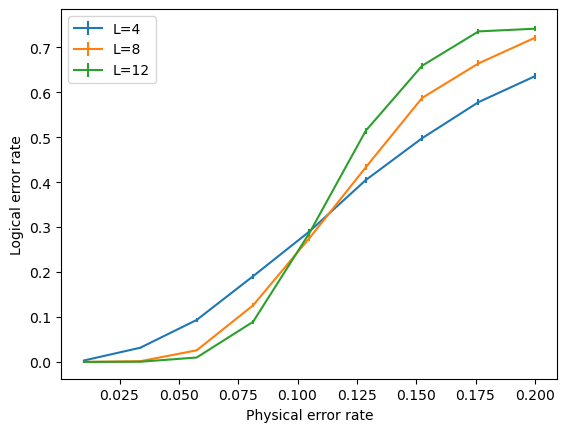

In [14]:
plt.figure()
for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="L={}".format(L))
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.legend(loc=0)

Nice, we see a similar threshold to MWPM. The BP(+OSD) threshold cannot exceed that of MWPM since both are trying to identify the minimum weight error. MWPM is supposed to do this exactly.

## Finite size scaling
Let us extract the threshold more accurately.

In [15]:
num_shots = 5000
Ls = range(4,14,4)
ps = np.linspace(0.08, 0.12, 14)
np.random.seed(2)
log_errors_all_L = []
for L in Ls:
    print("Simulating L={}...".format(L))
    H = toric.toric_code_z(L)
    log = toric.toric_code_logical_z(L)
    log_errors = []
    for p in ps:
        num_errors = num_decoding_failures(H, log, float(p), num_shots, {})
        log_errors.append(num_errors/num_shots)
    log_errors_all_L.append(np.array(log_errors))

Simulating L=4...
Simulating L=8...
Simulating L=12...


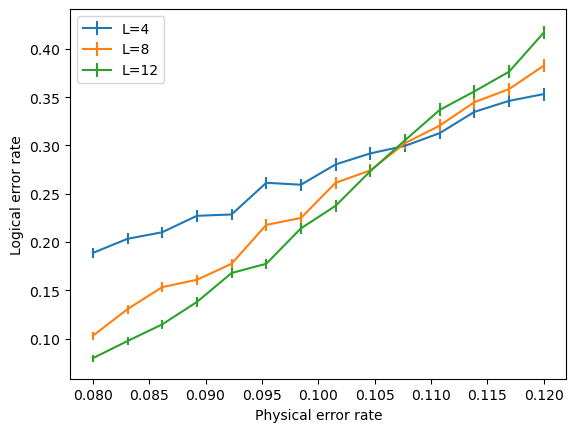

In [16]:
plt.figure()
std_err_all = []
for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    std_err_all.append(std_err)
    plt.errorbar(ps, logical_errors, yerr=std_err, label="L={}".format(L))
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.legend(loc=0)

In [17]:
res = fssa.autoscale(Ls, ps, np.array(log_errors_all_L), np.array(std_err_all), 0.103, 1, 1)

/home/sajant/Research/Berkeley/QEC/pyfssa/fssa/fssa.py:165: RuntimeWarning: rho_c is out of range
  warnings.warn("rho_c is out of range", RuntimeWarning)


In [18]:
res

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1.550411359171374
             x: [ 1.129e-01  1.635e+00  8.992e-02]
           nit: 40
          nfev: 75
 final_simplex: (array([[ 1.129e-01,  1.635e+00,  8.992e-02],
                       [ 1.131e-01,  1.631e+00,  9.420e-02],
                       [ 1.130e-01,  1.628e+00,  9.556e-02],
                       [ 1.130e-01,  1.631e+00,  9.681e-02]]), array([ 1.550e+00,  1.555e+00,  1.555e+00,  1.560e+00]))
         varco: [[ 3.324e-06  4.848e-04  5.795e-05]
                 [ 4.848e-04  1.831e-01 -2.102e-03]
                 [ 5.795e-05 -2.102e-03  4.550e-03]]
        errors: [ 1.823e-03  4.280e-01  6.745e-02]
           rho: 0.1128810145075807
            nu: 1.6346653814225647
          zeta: 0.08992262730180858
          drho: 0.0018231113292984241
           dnu: 0.4279581626325672
         dzeta: 0.06745409175246399

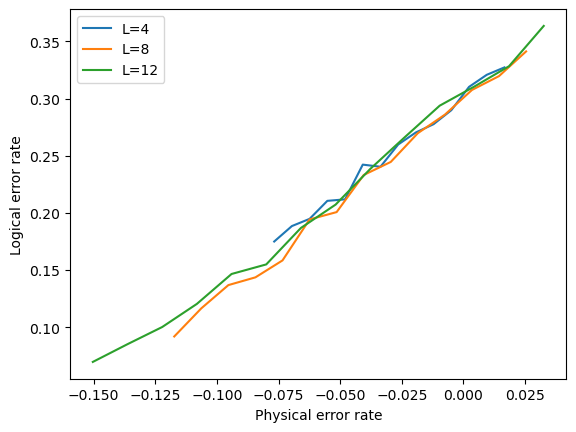

In [19]:
plt.figure()
for L, logical_errors in zip(Ls, log_errors_all_L):
    plt.plot((ps-res['rho'])*L**(1/res['nu']), logical_errors * L**(-res['zeta']/res['nu']), label="L={}".format(L))
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.legend(loc=0)

# Depolarizing error
For depolarizing error, we sample an random Pauli error with probability $p/3$ and an identity with $1-p$. The BP decoder does not account for correlations between the $X$ and $Z$ decoding problem. So we decode each separately. In principle we should ensure that for a given error string, both succeed. But since the problems are independent, we don't need to explicity do this. Really, there is no need to run depolarizing error. Depolarizing error can be treated as bit and phase flip errors with $p' = 2p /3$.

Let us make sure this is case when we ensure that both problem succeed.

In [20]:
def num_decoding_failures_depolarizing(H_X, H_Z, logicals_X, logicals_Z, error_probability, num_shots, BP_params, OSD=True, OSD_params={}, LSD=False, LSD_params={}):

    bp_X = build_decoder(H_X, error_probability, BP_params, OSD=OSD, OSD_params=OSD_params, LSD=LSD, LSD_params=LSD_params)
    bp_Z = build_decoder(H_Z, error_probability, BP_params, OSD=OSD, OSD_params=OSD_params, LSD=LSD, LSD_params=LSD_params)
    
    # pI, pX, pZ, pY
    noise = np.random.choice(np.array([0,1,2,3], dtype=np.int8), size=(num_shots, H_X.shape[1]), p=(1-error_probability,error_probability/3,error_probability/3,error_probability/3))
    # Treat Z as identity; combine I and Z, combine X and Y
    noise_X = (noise % 2).astype(np.uint8)
    # Treat X as identity; combine I and X, combine Z and Y
    noise_Z = ((noise - 1) >= 1).astype(np.uint8)

    # Syndrome for each noise
    shots_X = (noise_X @ H_Z.T) % 2
    shots_Z = (noise_Z @ H_X.T) % 2

    # What error actually occured? Check anticommutation of error with logical
    actual_observables_X = (noise_X @ logicals_Z.T) % 2
    actual_observables_Z = (noise_Z @ logicals_X.T) % 2
    actual_observables = np.column_stack([actual_observables_X, actual_observables_Z])
    
    # Do matching
    predicted_observables_X, predicted_observables_Z = [], []
    for sh_X, sh_Z in zip(shots_X, shots_Z):
        # This is the recovery string.
        predicted_observables_X.append(bp_Z.decode(sh_X))
        predicted_observables_Z.append(bp_X.decode(sh_Z))
    predicted_observables_X = (np.vstack(predicted_observables_X) @ logicals_Z.T) % 2
    predicted_observables_Z = (np.vstack(predicted_observables_Z) @ logicals_X.T) % 2
    predicted_observables = np.column_stack([predicted_observables_X, predicted_observables_Z])
    
    num_errors = np.sum(np.any(predicted_observables != actual_observables, axis=1))
    return num_errors

In [21]:
num_decoding_failures_depolarizing(toric.toric_code_x(5), toric.toric_code_z(5), toric.toric_code_logical_x(5), toric.toric_code_logical_z(5), 0.03, 200, 
                                   {}, OSD_params={'osd_method': 'OSD_0', 'osd_order': 0})

np.int64(0)

In [22]:
num_shots = 5000
Ls = range(4,14,4)
ps = np.linspace(0.12, 0.18, 9)
np.random.seed(2)
log_errors_all_L = []
for L in Ls:
    print("Simulating L={}...".format(L))
    Hx = toric.toric_code_x(L)
    logX = toric.toric_code_logical_x(L)
    Hz = toric.toric_code_z(L)
    logZ = toric.toric_code_logical_z(L)
    log_errors = []
    for p in ps:
        num_errors = num_decoding_failures_depolarizing(Hx, Hz, logX, logZ, float(p), num_shots, {}, OSD_params={'osd_method': 'OSD_0', 'osd_order': 0})
        log_errors.append(num_errors/num_shots)
    log_errors_all_L.append(np.array(log_errors))

Simulating L=4...
Simulating L=8...
Simulating L=12...


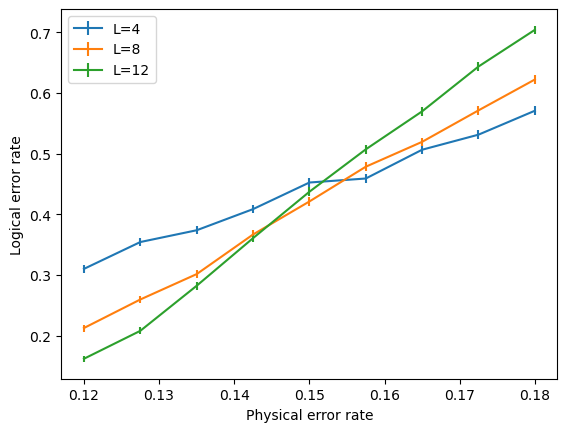

In [23]:
plt.figure()
std_err_all = []
for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    std_err_all.append(std_err)
    plt.errorbar(ps, logical_errors, yerr=std_err, label="L={}".format(L))
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.legend(loc=0)

In [24]:
res = fssa.autoscale(Ls, ps, np.array(log_errors_all_L), np.array(std_err_all), 0.15, 1, 1)

In [25]:
res

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 4.907945307520693
             x: [ 1.660e-01  1.727e+00  2.102e-01]
           nit: 59
          nfev: 107
 final_simplex: (array([[ 1.660e-01,  1.727e+00,  2.102e-01],
                       [ 1.660e-01,  1.728e+00,  2.098e-01],
                       [ 1.660e-01,  1.728e+00,  2.112e-01],
                       [ 1.661e-01,  1.733e+00,  2.131e-01]]), array([ 4.908e+00,  4.909e+00,  4.915e+00,  4.917e+00]))
         varco: [[ 6.755e-05  7.335e-03  9.563e-04]
                 [ 7.335e-03  8.218e-01  1.141e-01]
                 [ 9.563e-04  1.141e-01  2.459e-02]]
        errors: [ 8.219e-03  9.065e-01  1.568e-01]
           rho: 0.16595174364694484
            nu: 1.7266927734773945
          zeta: 0.21024071963990978
          drho: 0.008218684491683408
           dnu: 0.9065415210490089
         dzeta: 0.15682288431764516

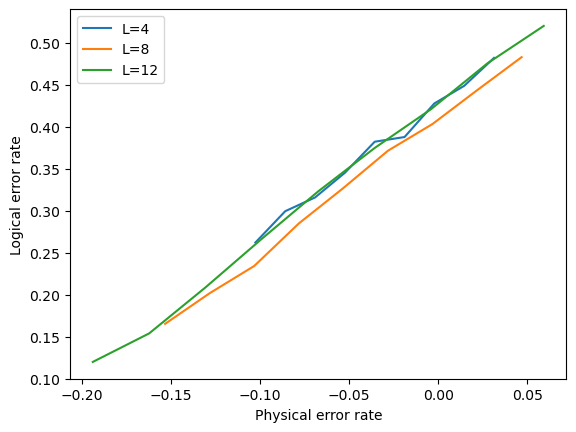

In [26]:
plt.figure()
for L, logical_errors in zip(Ls, log_errors_all_L):
    plt.plot((ps-res['rho'])*L**(1/res['nu']), logical_errors * L**(-res['zeta']/res['nu']), label="L={}".format(L))
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.legend(loc=0)

This works!

# Surface code

In [27]:
num_shots = 5000
Ls = range(4,14,4)
ps = np.linspace(0.08, 0.12, 9)
np.random.seed(2)
log_errors_all_L = []
for L in Ls:
    print("Simulating L={}...".format(L))
    H = toric.surface_code_z(L, 3)
    log = toric.surface_code_logical_z(L, 3)
    log_errors = []
    for p in ps:
        num_errors = num_decoding_failures(H, log, float(p), num_shots, {}, OSD_params={'osd_method': 'OSD_0', 'osd_order': 0})
        log_errors.append(num_errors/num_shots)
    log_errors_all_L.append(np.array(log_errors))

Simulating L=4...
Simulating L=8...
Simulating L=12...


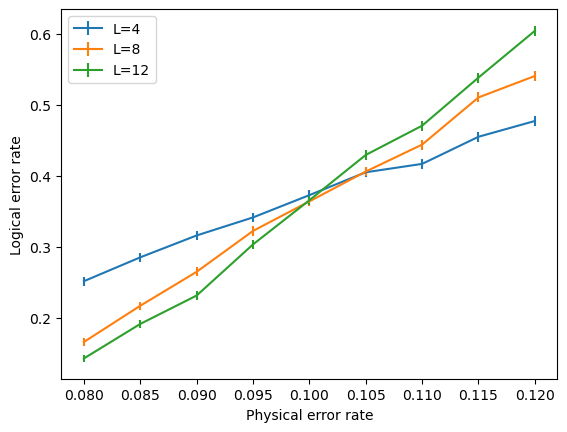

In [28]:
plt.figure()
std_err_all = []
for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    std_err_all.append(std_err)
    plt.errorbar(ps, logical_errors, yerr=std_err, label="L={}".format(L))
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.legend(loc=0)

In [29]:
res = fssa.autoscale(Ls, ps, np.array(log_errors_all_L), np.array(std_err_all), 0.1, 1, 1)
print(res['rho'])

0.11969815173795467
